This notebook demonstrates the process of building and training a simple Multi-Layer Perceptron (MLP) to classify handwritten digits from the MNIST dataset.

Here's a breakdown of the key steps:

1.  **Setup:** Necessary libraries (PyTorch, torchvision, matplotlib, numpy, scikit-learn) are imported.
2.  **Data Preparation:**
    *   The MNIST dataset is loaded and transformed into PyTorch tensors.
    *   The data is normalized using the mean and standard deviation of the MNIST training set.
    *   A DataLoader is created to efficiently provide mini-batches of data during training.
3.  **Model Definition:** A simple MLP model is defined with three fully connected layers and ReLU activation functions.
4.  **Loss Function and Optimizer:**
    *   Cross-Entropy Loss is chosen as the loss function, suitable for multi-class classification.
    *   The Adam optimizer is used to update the model's weights.
5.  **Training:** The model is trained for a specified number of epochs, iterating through the training data in batches, performing forward and backward passes, and updating the model's parameters. The loss is tracked and printed for each epoch.
6.  **Decision Boundary Visualization:** A function `plot_decision_boundary` is defined and used to visualize the decision boundary of the trained model in a 2D PCA-reduced feature space. This helps to understand how well the model separates the different digit classes.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define transformation: turn image into a tensor and normalize pixel values
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image or numpy array to PyTorch tensor and scales to [0,1]
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST, gives better/faster convergence
])

# Download and create the training dataset (images and labels for training)
trainset = datasets.MNIST(
    root='./data',       # Local directory to save data
    train=True,          # Use training set (not the test set)
    download=True,       # Download if not already exists
    transform=transform  # Apply the transformation defined above
)

# Create a DataLoader to efficiently provide mini-batches for training
trainloader = torch.utils.data.DataLoader(
    trainset,         # Our training dataset
    batch_size=64,    # How many images per batch
    shuffle=True      # Shuffle for randomness each epoch
)

In [3]:
# Define a simple Multi-Layer Perceptron (MLP) for classifying MNIST digits
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128) # First fully connected layer (input: 784 pixels, output: 128 features)
        self.fc2 = nn.Linear(128, 64)    # Second hidden layer (input: 128, output: 64)
        self.fc3 = nn.Linear(64, 10)     # Output layer (input: 64, output: 10 digits, 0-9)

    def forward(self, x):
        x = x.view(x.size(0), -1)        # Flatten the input image to a vector (batch_size, 784)
        x = torch.relu(self.fc1(x))      # Pass through first layer + ReLU activation
        x = torch.relu(self.fc2(x))      # Pass through second layer + ReLU activation
        x = self.fc3(x)                  # Output logits (no activation; loss will handle softmax)
        return x

model = MLP()

In [4]:
# Use CrossEntropyLoss (appropriate for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer (adjusts learning rate for each parameter)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
epochs = 6  # Number of complete passes through the dataset

for epoch in range(epochs):
    for images, labels in trainloader:         # Loop through batches
        outputs = model(images)                # Forward pass: get logits
        loss = criterion(outputs, labels)      # Compute loss
        optimizer.zero_grad()                  # Reset gradients
        loss.backward()                        # Backpropagation: compute gradients
        optimizer.step()                       # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}") # Track the loss every epoch


Epoch 1/6, Loss: 0.1292
Epoch 2/6, Loss: 0.2319
Epoch 3/6, Loss: 0.1097
Epoch 4/6, Loss: 0.1779
Epoch 5/6, Loss: 0.2940
Epoch 6/6, Loss: 0.0644


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
import torch

def plot_decision_boundary(model, data_loader):
    # Set model to eval mode for inference
    model.eval()

    # Lists to hold features and labels
    features = []
    labels = []

    # Extract features from first hidden layer (after ReLU)
    with torch.no_grad():
        for images, targets in data_loader:
            x = images.view(images.size(0), -1)  # flatten
            hidden_feats = torch.relu(model.fc1(x)).numpy()
            features.append(hidden_feats)
            labels.append(targets.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Reduce to 2D for visualization
    pca = PCA(n_components=2)
    features_2d = pca.fit_transform(features)

    # Create a meshgrid in the 2D PCA feature space
    x_min, x_max = features_2d[:, 0].min() - 1, features_2d[:, 0].max() + 1
    y_min, y_max = features_2d[:, 1].min() - 1, features_2d[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # Predict function to classify points in PCA space
    # We need to map back points to original feature space approx by inverse_transform of PCA
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_points_original = pca.inverse_transform(mesh_points)

    # Convert mesh points to tensor and apply second part of model (fc2, fc3)
    with torch.no_grad():
        mesh_tensor = torch.tensor(mesh_points_original, dtype=torch.float32)
        out = model.fc2(mesh_tensor)
        out = torch.relu(out)
        out = model.fc3(out)
        preds = torch.argmax(out, dim=1).numpy()

    preds = preds.reshape(xx.shape)

    # Plotting
    cmap_light = ListedColormap([
        '#FFFACD', '#FAEBD7', '#E0FFFF', '#FFE4E1', '#F0FFF0',
        '#FFF0F5', '#F5F5DC', '#F0FFFF', '#F5F5F5', '#FFEFD5'])

    cmap_bold = ListedColormap([
        '#FFD700', '#FF7F50', '#00CED1', '#FF6347', '#66CDAA',
        '#BA55D3', '#4682B4', '#7FFF00', '#DC143C', '#8A2BE2'])

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, preds, cmap=cmap_light, alpha=0.6)
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels,
                          cmap=cmap_bold, edgecolor='k', s=40)
    plt.legend(*scatter.legend_elements(), title="Digits")
    plt.title("Decision Boundary of MLP on MNIST (PCA reduced features)")
    plt.xlabel("PCA Feature 1")
    plt.ylabel("PCA Feature 2")
    plt.show()

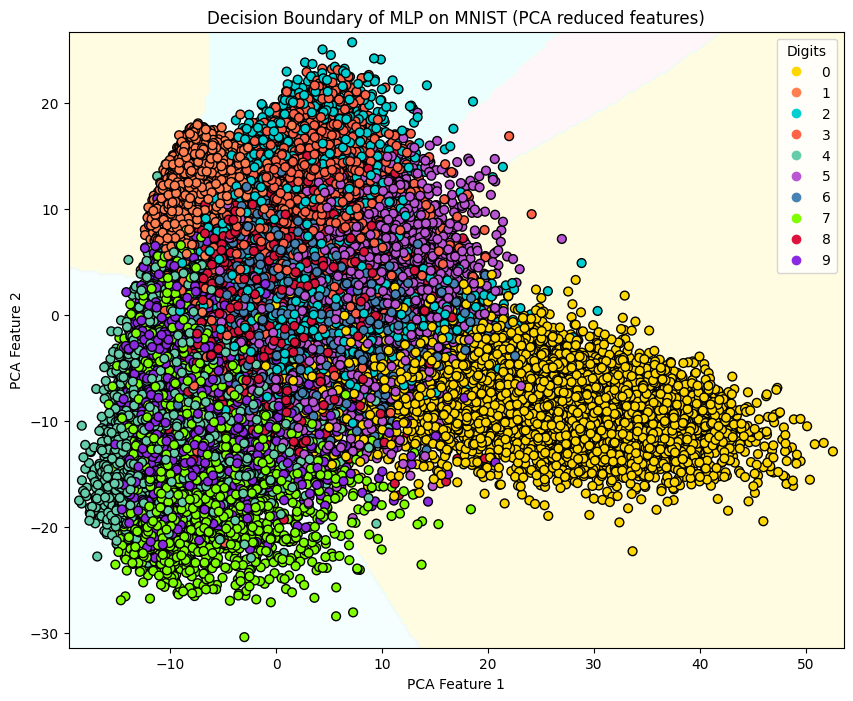

In [7]:
plot_decision_boundary(model, trainloader)